### Edgar Moises Hernandez-Gonzalez
#### 18/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM)
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (4, 264) #ancho, alto
  fs = 250
  datos = np.zeros((6048,264,4))
  temporal = np.zeros((528,2))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [11]:
print(x_train.shape)
print(x_test.shape)

(6048, 264, 4)
(6048, 264, 4)


In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

67.42340492222856
55.28679494298277
0.00015417410020847705
0.00044794910241258623


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 68.0
x_test /= 68.0

In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.9915207
0.81304115
2.2672662e-06
6.587487e-06


In [15]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 1, 264, 4, 1)
(6048, 1, 264, 4, 1)


In [0]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32, dropout=0.2))
  model.add(Dense(16))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def Conv_LSTM_2D_BN():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
loss:  0.8737656655450347
accuracy:  0.6140872836112976
kappa:  0.48544973544973546
confusion matrix:
 [[ 888  360  201   63]
 [ 471  796  227   18]
 [  61   17  995  439]
 [  86    3  388 1035]]


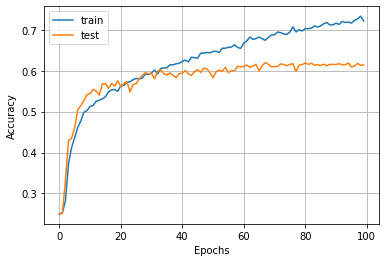

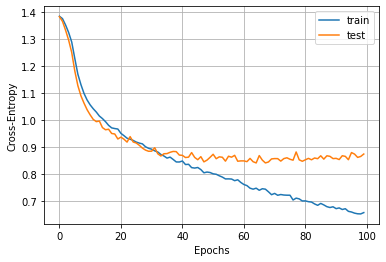

Iteration: 2
loss:  0.883858308353752
accuracy:  0.5940806865692139
kappa:  0.45877425044091713
confusion matrix:
 [[ 732  502  240   38]
 [ 391  910  187   24]
 [  56   13  916  527]
 [  68    7  402 1035]]


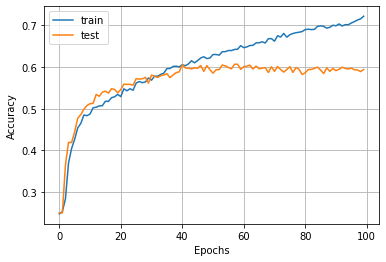

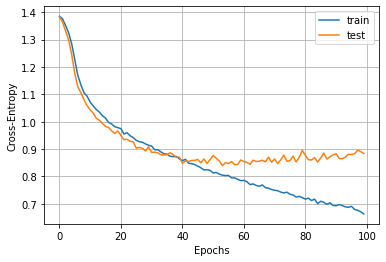


Resultados:
loss: [0.8737656655450347, 0.883858308353752]
accuracy: [0.6140872836112976, 0.5940806865692139]
kappa: [0.48544973544973546, 0.45877425044091713]


In [24]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  #model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=100, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [25]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_43 (TimeDis (None, 1, 264, 4, 128)    1280      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 1, 132, 2, 128)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 1, 132, 2, 128)    147584    
_________________________________________________________________
time_distributed_46 (TimeDis (None, 1, 66, 1, 128)     0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 66, 1, 128)     147584    
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 8448)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)               

In [26]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6041
std: (+/- 0.0100)
Mean Kappa: 0.4721
std: (+/- 0.0133)
Max Accuracy: 0.6141
Max Kappa: 0.4854
